Important: Our road matrix is different from the figure of numbers in the paper. In our code, the number represents the velocity after the car motion.


1207668547


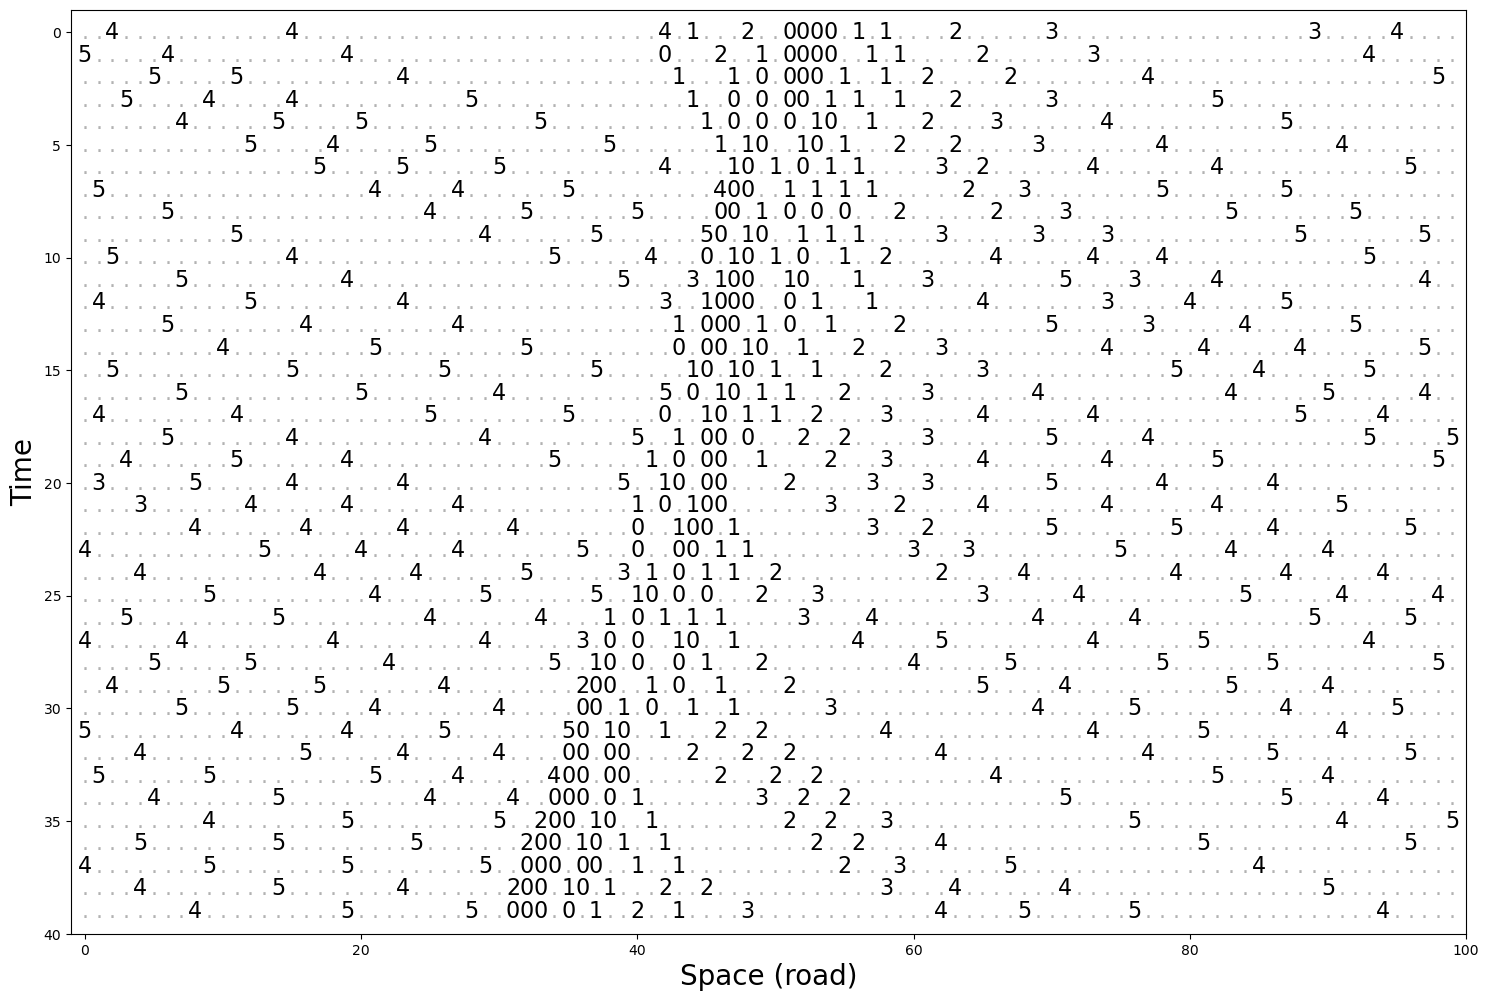

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
# if you don't wanna see the process of the code, just remove next line
from tqdm import tqdm

# set the seed to test the code for same result
 

current_seed = np.random.randint(0, 2**31 - 1)
np.random.seed(current_seed)
print(current_seed)

# initialize the road, -1 for empty , 0 represent cars with 0 velocity
def initialize_road(length, num_cars):
    road = np.full(length, -1) 
    car_positions = np.random.choice(length, num_cars, replace=False)
    road[car_positions] = 0  
    return road

# calculate the distance between two cars inside loop
def get_distance_to_next_car_loop(road, pos):
    length = len(road)

    # check if the current position is valid
    if pos < 0 or pos >= length:
        raise ValueError("Current position is out of range")
    
    # check if there is a car at the current position
    if road[pos] == -1:
        raise ValueError("There is no car at the current position")
    
    distance = 1
    for i in range(1, length):
        next_pos = (pos + i) % length
        if road [next_pos] >= 0:
            return distance
        distance += 1
    return distance

# code for update traffic for each step
def update_traffic(road, vmax=5, p=0.3):
    length = len(road)
    new_road = np.full(length, -1)
    
    for i in range(length):
        if road[i] >= 0:  
            v = road[i]  
            
            # Step 1: Acceleration
            if v < vmax:
                v += 1
            
            # Step 2: Slowing down
            dist = get_distance_to_next_car_loop(road, i)
            v = min(v, dist - 1)
            

            # Step 3: Randomization
            if v > 0 and np.random.random() < p:
                v -= 1
            
            # Step 4: Car motion
            new_pos = (i + v) % length
            new_road[new_pos] = v
    return new_road

# code for calculating measurement parameters(flow, density, avg_velocity)
def calculate_traffic_measurements(road):
    length = len(road)
   
    measure_point = 95
    cars = road[road >= 0]

    density = len(cars) / length
    avg_velocity = np.mean(cars) if len(cars) > 0 else 0
    flow = 0
    for end_pos in range(length):
        if road[end_pos] > 0:
            velocity = road[end_pos]
            start_pos = (end_pos - velocity) % length
            
            # Normal case
            if start_pos < end_pos:
                    if start_pos <= measure_point < end_pos:
                        flow += 1
            else:
                # cross boundary
                if start_pos <= measure_point or measure_point < end_pos:
                    flow += 1

    return flow, density, avg_velocity

# code running the simulation
def run_simulation(length, num_cars, t0, steps, vmax=5, p=0.3):
    road = initialize_road(length, num_cars)
    
    # first run the code t0 times, and begin the collection of data after the first t0 time steps
    for i in range(t0):
        road = update_traffic(road, vmax, p)

    flows = []
    densities = []
    velocities = []
    
    road_matrix = np.zeros((steps, length), dtype=int)
    road_matrix[0] = road

    for step in range(steps):
        flow, density, velocity = calculate_traffic_measurements(road)
        flows.append(flow)
        densities.append(density)
        velocities.append(velocity)
        
        road = update_traffic(road, vmax, p)
        if step < steps - 1:
            road_matrix[step + 1] = road


    return np.array(flows), np.array(densities), np.array(velocities), road_matrix

# code for space_time_diagram
def plot_space_time_diagram(road_matrix):
    steps, length = road_matrix.shape
    space_time_diagram = np.full((steps, length), '.', dtype = str)

    for i in range(steps):
        for j in range(length):
            if road_matrix[i,j] >= 0:
                space_time_diagram[i,j] = str(road_matrix[i,j])

    plt.figure(figsize=(18,12))

    plt.xlim(-1, length)
    plt.ylim(steps, -1)
    for i in range(steps):
        for j in range(length):
            if space_time_diagram[i,j] != '.':
                plt.text(j, i, space_time_diagram[i,j], ha='center', va='center', fontsize = 16)
            else:
                plt.text(j, i, '.', ha='center', va='center', alpha=0.3, fontsize=16)

    plt.xlabel('Space (road)', fontsize = 20)
    plt.ylabel('Time', fontsize = 20)


    plt.show()

# to test the code for plotting space_time_diagram, just remove the number sign in front of next two line
#_, _, _, road_matrix = run_simulation(length=100, num_cars=15, t0=200, steps=40, vmax=5, p=0.4)
#diagram = plot_space_time_diagram(road_matrix)


# code for speed-density diagram
def simulate_multiple_densities(road_length=1000, t0 = 500, time_steps_short=100, time_steps_long=10000):
    densities = np.linspace(0, 0.8, 100)  
    flows_short = []
    flows_short_2 = []
    flows_long = []
    
    # for density in densities:
    # this is the same as above, just to see the process of the coding since it's really slow(>30 min)
    for density in tqdm(densities, desc="Simulating"):
        num_cars = int(density * road_length)  # Scale to match x-axis units
        
        # short-term simulation (100 time steps)
        flows, _, _, _ = run_simulation(road_length, num_cars, t0, time_steps_short)
        flows_short.append(np.mean(flows))
        
        flows, _, _, _ = run_simulation(road_length, num_cars, t0, time_steps_short)
        flows_short_2.append(np.mean(flows))
        
        # long-term simulation (10000 time steps)
        flows, _, _, _ = run_simulation(road_length, num_cars, t0, time_steps_long)
        flows_long.append(np.mean(flows))
    
    max_flow = max(flows_long)
    max_density = densities[np.argmax(flows_long)]
    
    # plot results
    plt.figure(figsize=(8, 6))
    plt.scatter(densities, flows_short, alpha=0.5, s=20, color='black', label='100 time steps')
    plt.scatter(densities, flows_short_2, alpha=0.5, s=20, color='black')
    plt.plot(densities, flows_long, '-', color='black', label='10000 time steps')
    
    plt.xlabel('density [cars per site]')
    plt.ylabel('flow [cars per time step]')
    plt.title('Density-Flow Diagram')
    plt.grid(True, alpha=0.3)
    plt.xlim(0, 0.8)
    plt.ylim(0, 1)
    
    plt.legend()
    plt.show()
    
    return max_flow, max_density

# to test the code for plotting density-flow diagram, just remove the number sign in front of next line
# max_density, max_flow = simulate_multiple_densities()
# print(f"Max flow point: ({max_density:.2f}, {max_flow:.2f})")

# code for flow-time plot (useless)
def plot_flow_time(length, num_cars, t0, steps, vmax, p):
    flows, _, velocities, road_martix = run_simulation(length, num_cars, t0, steps, vmax, p)
    time = np.arange(steps)
    plt.figure(figsize=(12, 6))
    plt.plot(time, flows, 'k-', linewidth=1, alpha=0.7)
    plt.axhline(y=np.mean(flows), color='r', linestyle='--', 
                label=f'Mean flow: {np.mean(flows):.3f}')

    plt.show()

# plot_flow_time(length=10000, num_cars=1000, t0 = 1000, steps=1000, vmax=5, p=0.3)

In [3]:
# the code below create below shows how cars are moving in closed loop in our model
# to test the code, just remove all the number sign
from matplotlib.animation import FuncAnimation, PillowWriter

np.random.seed(current_seed)
road_length = 50  
num_cars = 20
road = np.full(road_length, -1) 
car_positions = np.random.choice(road_length, num_cars, replace=False)
road[car_positions] = 0  

# pre run the simulation
t0 = 100
for i in range(t0):
        road = update_traffic(road)
 
circle_radius = 5  

fig, ax = plt.subplots(figsize=(6, 6), subplot_kw={'projection': 'polar'})  
cars_scatter = None
velocities_text = []


def init():
    theta = np.linspace(0, 2*np.pi, 100)  
    ax.plot(theta, np.full_like(theta, circle_radius), 'k-', lw=2)  
    ax.set_xticks([])  
    ax.set_yticks([])
    ax.set_ylim(0, circle_radius + 1)  


    ax.text(3 * np.pi / 2, circle_radius + 2, "Cars moving counterclockwise", ha='center', va='center', fontsize=18, color='black', fontweight='bold')
    
    fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

def animate(frame):
    
    global road, cars_scatter, velocities_text
    
    # to remove staff in last frame
    for text in velocities_text:
        text.remove()
    velocities_text = []
    
    if cars_scatter:
        cars_scatter.remove()

    road = update_traffic(road)

    
    car_positions = np.where(road >= 0)[0]
    
    # theta = index/ length * 2pi
    angles = car_positions / road_length * 2 * np.pi  
    radius_array = np.full_like(angles, circle_radius)  

    cars_scatter = ax.scatter(angles, radius_array, c='red', s=100, label="Cars")

    for pos, angle in zip(car_positions, angles):
        text = ax.text(angle, circle_radius + 0.3, str(road[pos]), ha='center', va='center', fontsize=10, color='blue')
        velocities_text.append(text)



anim = FuncAnimation(fig, animate, init_func=init, frames=300, interval=200)

writer = PillowWriter(fps=3)
anim.save('closed_loop_simulation.gif', writer=writer)
plt.close()